# What is anamolies?

An anomaly in a data series is a significant deviation from some reasonable value. Looking at this series of numbers. 

For example, which number stands out?

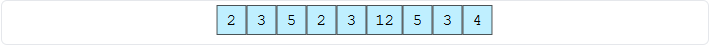

The number that stands out in this series is 12.

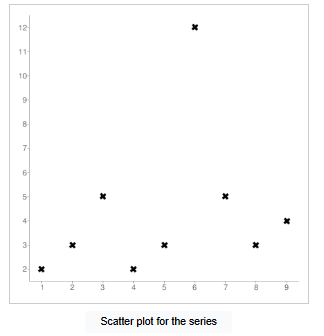

This is intuitive to a human, but computer programs do not have that intuition.

# Mathemactical foundation



```mysql
SELECT avg(n)
FROM unnest(array[2, 3, 5, 2, 3, 12, 5, 3, 4]) AS n;
```

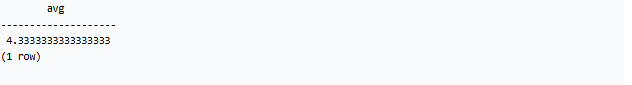

The mean is ~4.33. Next, we need to define the deviation. 

```mysql
SELECT stddev(n)
FROM unnest(array[2, 3, 5, 2, 3, 12, 5, 3, 4]) AS n;
```

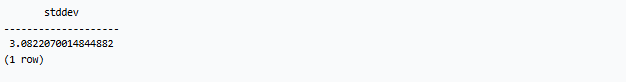

**Standard deviation** is the square root of the variance, which is the average squared distance from the mean. 

In this case, it is `3.08`.

Now that we have defined a **“reasonable”** value and a deviation, we can define a range of acceptable values.

```mysql
SELECT
   avg(n) - stddev(n) AS lower_bound,
   avg(n) + stddev(n) AS upper_bound
FROM
   unnest(array[2, 3, 5, 2, 3, 12, 5, 3, 4]) AS n;
;
````

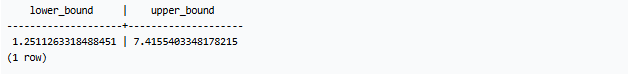

The range we defined is **1 standard deviation from the mean**, that is, `mean ± (1 * stddev)`.
Any value outside this range is considered an anomaly:

```mysql
WITH series AS (
   SELECT *
   FROM unnest(array[2, 3, 5, 2, 3, 12, 5, 3, 4]) AS n
),
bounds AS (
   SELECT
       avg(n) - stddev(n) AS lower_bound,
       avg(n) + stddev(n) AS upper_bound
   FROM
       series
)
SELECT
   n,
   n NOT BETWEEN lower_bound AND upper_bound AS is_anomaly
FROM
   series,
   bounds;
```

```
 n  | is_anomaly 
----+------------
  2 | f
  3 | f
  5 | f
  2 | f
  3 | f
 12 | t
  5 | f
  3 | f
  4 | f
(9 rows)
```

# Understanding Z-score

Another way to represent a range of acceptable values is using a `z-score`. **Z-score**, sometimes called standard score, is the number of standard deviations from the mean. 

In the previous section, our acceptable range was **1 standard deviation from the mean**, or in other words, a **z-score** in the range `±1`.

```mysql
WITH series AS (
   SELECT *
   FROM unnest(array[2, 3, 5, 2, 3, 12, 5, 3, 4]) AS n
),
stats AS (
   SELECT
       avg(n) series_mean,
       stddev(n) as series_stddev
   FROM
       series
)
SELECT
   n,
   (n - series_mean) / series_stddev as zscore
FROM
   series,
   stats;q
```

```
 n  |         zscore          
----+-------------------------
  2 | -0.75703329861022517346
  3 | -0.43259045634870009448
  5 |  0.21629522817435006346
  2 | -0.75703329861022517346
  3 | -0.43259045634870009448
 12 |      2.4873951240050256
  5 |  0.21629522817435006346
  3 | -0.43259045634870009448
  4 | -0.10814761408717501551
(9 rows)

```

Like before, we can detect anomalies by searching for values that are outside the acceptable range using the z-score:

```mysql
WITH series AS (
   SELECT *
   FROM unnest(array[2, 3, 5, 2, 3, 12, 5, 3, 4]) AS n
),
stats AS (
   SELECT
       avg(n) series_avg,
       stddev(n) as series_stddev
   FROM
       series
),
zscores AS (
   SELECT
       n,
       (n - series_avg) / series_stddev AS zscore
   FROM
       series,
       stats
)
SELECT
   *,
   zscore NOT BETWEEN -1 AND 1 AS is_anomaly
FROM
   zscores;
```

```
 n  |         zscore          | is_anomaly 
----+-------------------------+------------
  2 | -0.75703329861022517346 | f
  3 | -0.43259045634870009448 | f
  5 |  0.21629522817435006346 | f
  2 | -0.75703329861022517346 | f
  3 | -0.43259045634870009448 | f
 12 |      2.4873951240050256 | t
  5 |  0.21629522817435006346 | f
  3 | -0.43259045634870009448 | f
  4 | -0.10814761408717501551 | f
(9 rows)
```

> **Using the z-score, we identified 12 as an anomaly in this series**.


# Optimizing Z-score

So far, we have used one standard deviation from the mean or a **z-score** of `±1` to identify anomalies. 

Changing the **z-score** threshold can affect our results. 

For example, let’s see what anomalies we identify when the **z-score** is greater than `0.5` and when it is greater than `3`:

```mysql
WITH series AS (
   SELECT *
   FROM unnest(array[2, 3, 5, 2, 3, 12, 5, 3, 4]) AS n
),
stats AS (
   SELECT
       avg(n) series_avg,
       stddev(n) as series_stddev
   FROM
       series
),
zscores AS (
   SELECT
       n,
       (n - series_avg) / series_stddev AS zscore
   FROM
       series,
       stats
)
SELECT
   *,
   zscore NOT BETWEEN -0.5 AND 0.5 AS is_anomaly_0_5,
   zscore NOT BETWEEN -1 AND 1 AS is_anomaly_1,
   zscore NOT BETWEEN -3 AND 3 AS is_anomaly_3
FROM
   zscores;
```

```
 n  |         zscore          | is_anomaly_0_5 | is_anomaly_1 | is_anomaly_3 
----+-------------------------+----------------+--------------+--------------
  2 | -0.75703329861022517346 | t              | f            | f
  3 | -0.43259045634870009448 | f              | f            | f
  5 |  0.21629522817435006346 | f              | f            | f
  2 | -0.75703329861022517346 | t              | f            | f
  3 | -0.43259045634870009448 | f              | f            | f
 12 |      2.4873951240050256 | t              | t            | f
  5 |  0.21629522817435006346 | f              | f            | f
  3 | -0.43259045634870009448 | f              | f            | f
  4 | -0.10814761408717501551 | f              | f            | f
(9 rows)
```
Let’s see what we got:
* When we decreased the **z-score** threshold to `0.5`, we identified the value `2` as an anomaly in addition to the value `12`.
* When we increased the **z-score** threshold to `3`, we did not identify any anomaly.

The quality of our results is directly related to the parameters we set for the query. 

Later, we will see how using backtesting can help us identify ideal values.

# Getting a Sense of the Data

To get a sense of the data, let’s draw a stacked bar chart by status:

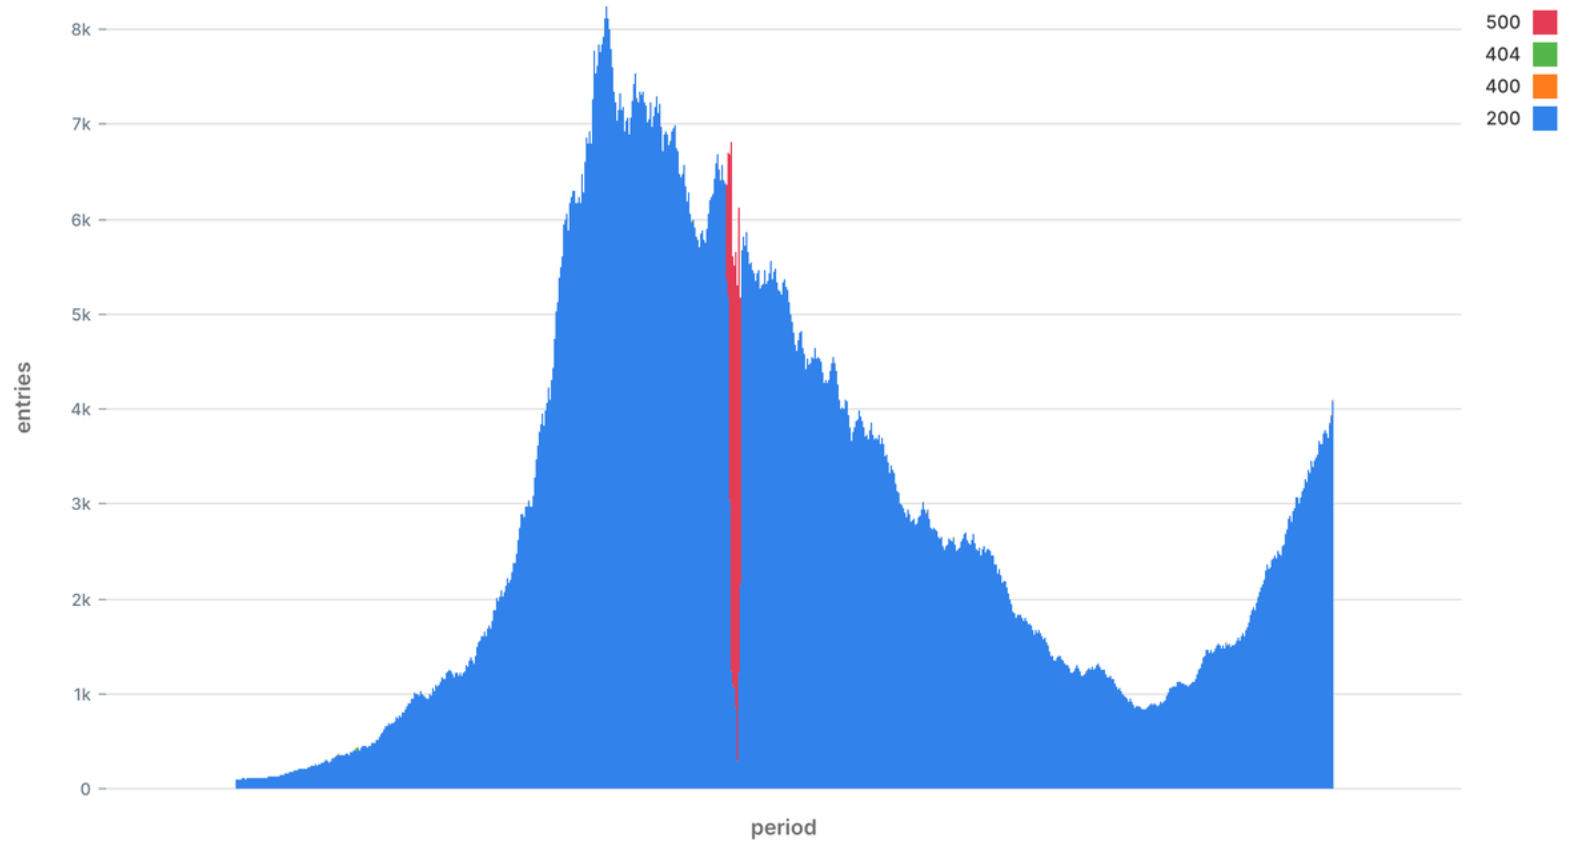

The chart shows a period of **12 hours**. 
* It looks like we have a nice trend with two peaks at around `09:30` and again at `18:00`.
* We can notice right away that at around `11:30`, there was a significant increase in **500 status code errors**. 
* The burst died down after around 10 minutes.
* This is the type of anomaly we want to identify early on.
* It is entirely possible that there were other problems during that time; we can’t spot them with the naked eye.

# Data in server logs

Application servers such as Nginx, Apache, and IIS write very useful information to access logs. The data in these logs can be instrumental in identifying anomalies.

We will analyze logs of a web application, so the data we are most interested in is the timestamp and the status code of every response from the server. 

To illustrate the type of insight, we can draw from this data:
* A sudden increase in the `500` status code:
    * You may have a problem with the server.
    * Did you push a new version?
    * Is there an external service you are using that started failing in unexpected ways?
* A sudden increase in the `400` status code:
    * You may have a problem with the client.
    * Did you change some validation logic and forget to update the client?
    * Did you make a change and forget to handle backward compatibility?
* A sudden increase in the `404` status code:
    * You may have an SEO problem.
    * Did you move some pages and forget to set up redirects?
    * Is there some script kiddy running a scan on your site?

A sudden increase in the **200 status code**: 
* You either have some significant legit traffic coming in or are under a DOS attack.
* Either way, you probably want to check where it is coming from.

# Preparing the data

Parsing and processing logs are outside the scope of this course, but let’s assume we did that. 

By the end, we’ll have a table that looks like this:

```mysql
CREATE TABLE server_log_summary AS (
   period timestamptz,
   status_code int,
   entries int
);
```

* The table stores the number of entries for each status code for a given period.
* For example, our table stores how many responses are returned each status code every minute.

```mysql
CREATE TABLE server_log_summary (
   status_code int,
   period timestamptz,
   entries int
);

\COPY server_log_summary(status_code, period, entries) FROM '/data.csv' DELIMITER ',' CSV HEADER;

SELECT * FROM server_log_summary ORDER BY period DESC LIMIT 10;
```

```
CREATE TABLE
COPY 2892
 status_code |         period         | entries 
-------------+------------------------+---------
         500 | 2020-08-01 18:00:00+00 |       0
         200 | 2020-08-01 18:00:00+00 |    4084
         404 | 2020-08-01 18:00:00+00 |       0
         400 | 2020-08-01 18:00:00+00 |      24
         500 | 2020-08-01 17:59:00+00 |       0
         404 | 2020-08-01 17:59:00+00 |       0
         200 | 2020-08-01 17:59:00+00 |    3927
         400 | 2020-08-01 17:59:00+00 |      12
         500 | 2020-08-01 17:58:00+00 |       0
         404 | 2020-08-01 17:58:00+00 |       0
(10 rows)

```

* Note that the table has a row for every minute, even if the status code was never returned in that minute. 
* Given a table of statuses, it is very tempting to do something like this.

```mysql
-- Wrong!
SELECT
   date_trunc('minute', timestamp) AS period,
   status_code,
   count(*) AS entries
FROM
   server_log
GROUP BY
   period,
   status_code;
```

* This is a common mistake that can leave you with gaps in the data. 
* Zero is a value, and it holds a significant meaning. 
* A better approach is to create an **“axis”** and join to it.

```mysql
-- Correct!
WITH axis AS (
   SELECT
       status_code,
       generate_series(
           date_trunc('minute', now()),
           date_trunc('minute', now() - interval '1 hour'),
           interval '1 minute' * -1
       ) AS period
   FROM (
       VALUES (200), (400), (404), (500)
   ) AS t(status_code)
)
SELECT
   a.period,
   a.status_code,
   count(*) AS entries
FROM
   axis a
   LEFT JOIN server_log l ON (
       date_trunc('minute', l.timestamp) = a.period
       AND l.status_code = a.status_code
   )
GROUP BY
   period,
   status_code;
```

First, we should generate an axis using a Cartesian join between the status codes we want to track and the times we want to monitor. 

To generate the axis, we can use two nice features of PostgreSQL:
* `generate_series`: A function that generates a range of values.
* `VALUES` list: A special clause that can generate **“constant tables”**, as the documentation calls it. You might be familiar with the `VALUES` clause from `INSERT` statements. In the old days, to generate data, we had to use a bunch of `SELECT … UNION ALL…` Using `VALUES` is much nicer.

After generating the axis, we left to join the actual data to get a complete series for each status code. The resulting data has no gaps and is ready for analysis.

# Identifying Anomalies

In anomaly detection systems, we usually want to identify if we have an anomaly right now, and send an alert.

To identify if the last data point is an anomaly, we start by calculating the mean and standard deviation for each status code in the past hour:

```mysql
CREATE TABLE server_log_summary (
   status_code int,
   period timestamptz,
   entries int
);

\COPY server_log_summary(status_code, period, entries) FROM '/data.csv' DELIMITER ',' CSV HEADER;

WITH stats AS (
   SELECT
       status_code,
       (MAX(ARRAY[EXTRACT('epoch' FROM period), entries]))[2] AS last_value,
       AVG(entries) AS mean_entries,
       STDDEV(entries) AS stddev_entries
   FROM
       server_log_summary
   WHERE
        period > '2020-08-01 17:00 UTC'::timestamptz
   GROUP BY
       status_code
)
SELECT * FROM stats;
```

```
CREATE TABLE
COPY 2892
 status_code | last_value |      mean_entries      |     stddev_entries     
-------------+------------+------------------------+------------------------
         500 |          0 | 0.15000000000000000000 | 0.36008473579027553993
         200 |       4084 |  2779.1000000000000000 |       689.219644702665
         404 |          0 | 0.13333333333333333333 | 0.34280333180088158345
         400 |         24 | 0.73333333333333333333 |     3.4388935285299212
(4 rows)
```

To get the last value in a `GROUP BY` and the mean and standard deviation, we used a little array trick.

Next, we calculate the z-score for the last value for each status code:

```mysql
WITH stats AS (
   SELECT
       status_code,
       (MAX(ARRAY[EXTRACT('epoch' FROM period), entries]))[2] AS last_value,
       AVG(entries) AS mean_entries,
       STDDEV(entries) AS stddev_entries
   FROM
       server_log_summary
   WHERE
       period > '2020-08-01 17:00 UTC'::timestamptz
   GROUP BY
       status_code
)
SELECT
   *,
   (last_value - mean_entries) / NULLIF(stddev_entries::float, 0) as zscore
FROM
   stats;
```

```
CREATE TABLE
COPY 2892
 status_code | last_value |      mean_entries      |     stddev_entries     |       zscore       
-------------+------------+------------------------+------------------------+--------------------
         500 |          0 | 0.15000000000000000000 | 0.36008473579027553993 |  -0.41656861591424
         200 |       4084 |  2779.1000000000000000 |       689.219644702665 |   1.89330064810173
         404 |          0 | 0.13333333333333333333 | 0.34280333180088158345 | -0.388949934158693
         400 |         24 | 0.73333333333333333333 |     3.4388935285299212 |   6.76574208350464
(4 rows)

```

* We calculated the **z-score** by finding the number of standard deviations between the last value and the mean. 
* To avoid a **“division by zero”** error, we transform the denominator to `NULL`.
* Looking at the **z-scores** we got, we can spot that status code `400` received a very high **z-score** of **6**.
* In the past minute, we returned a `400` status code `24` times, which is significantly higher than the average of `0.73` in the past hour.

Let’s take a look at the raw data:

```mysql
SELECT * FROM server_log_summary WHERE status_code = 400 ORDER BY period DESC LIMIT 20;
```

```
CREATE TABLE
COPY 2892
 status_code |         period         | entries 
-------------+------------------------+---------
         400 | 2020-08-01 18:00:00+00 |      24
         400 | 2020-08-01 17:59:00+00 |      12
         400 | 2020-08-01 17:58:00+00 |       2
         400 | 2020-08-01 17:57:00+00 |       0
         400 | 2020-08-01 17:56:00+00 |       1
         400 | 2020-08-01 17:55:00+00 |       0
         400 | 2020-08-01 17:54:00+00 |       0
         400 | 2020-08-01 17:53:00+00 |       0
         400 | 2020-08-01 17:52:00+00 |       0
         400 | 2020-08-01 17:51:00+00 |       0
         400 | 2020-08-01 17:50:00+00 |       0
         400 | 2020-08-01 17:49:00+00 |       0
         400 | 2020-08-01 17:48:00+00 |       0
         400 | 2020-08-01 17:47:00+00 |       0
         400 | 2020-08-01 17:46:00+00 |       0
         400 | 2020-08-01 17:45:00+00 |       0
         400 | 2020-08-01 17:44:00+00 |       0
         400 | 2020-08-01 17:43:00+00 |       0
         400 | 2020-08-01 17:42:00+00 |       0
         400 | 2020-08-01 17:41:00+00 |       0
(20 rows)
```

It does look like in the last couple of minutes, and we are getting more errors than expected.

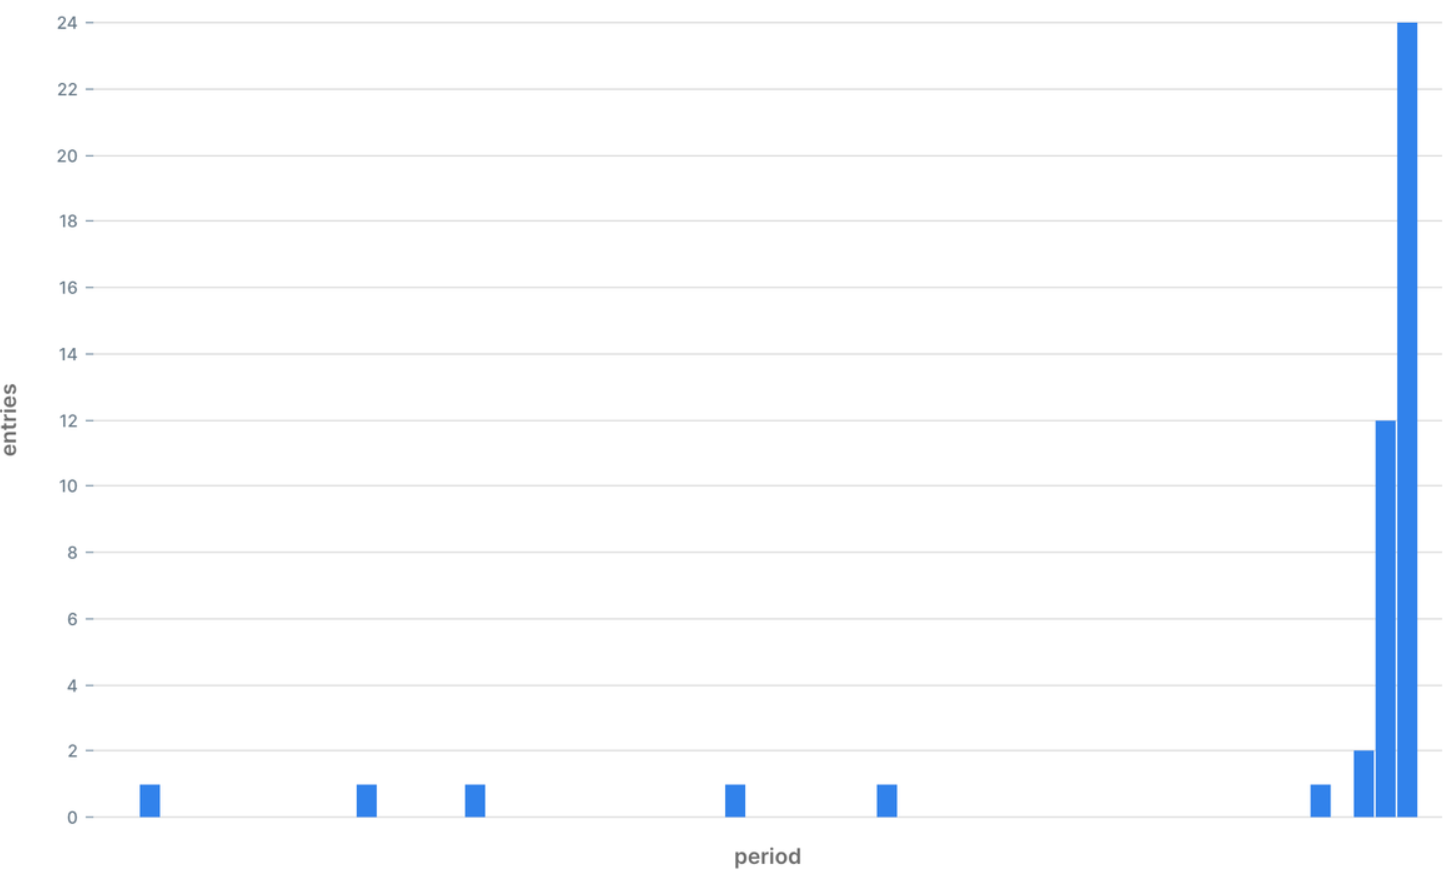

What our naked eye missed in the chart and the raw data was found by the query and was classified as an anomaly. We are off to a great start!


# Finding Past Anomalies

In the previous section, we identified an anomaly. 
* We found an increase in the `400` status code because the **z-score** was `6`.
* But how do we set the threshold for the **z-score**?
* Is a **z-score** of `3` an anomaly?
* What about `2`, or `1`?

To find thresholds that fit our needs, we can run simulations on past data with different values and evaluate the results. This is often called **backtesting**.
* The first thing we need to do is to calculate the mean and the standard deviation for each status code up until every row, just as if it were the current value.
* This is a classic job for a window function.

```mysql
WITH calculations_over_window AS (
   SELECT
      status_code,
      period,
      entries,
      AVG(entries) OVER status_window as mean_entries,
      STDDEV(entries) OVER status_window as stddev_entries
   FROM
      server_log_summary
   WINDOW status_window AS (
      PARTITION BY status_code
      ORDER BY period
      ROWS BETWEEN 60 PRECEDING AND CURRENT ROW
   )
)
SELECT *
FROM calculations_over_window
ORDER BY period DESC
LIMIT 20;
```

```
CREATE TABLE
COPY 2892
 status_code |         period         | entries |      mean_entries      |     stddev_entries     
-------------+------------------------+---------+------------------------+------------------------
         200 | 2020-08-01 18:00:00+00 |    4084 |  2759.9672131147540984 |       699.597407256800
         400 | 2020-08-01 18:00:00+00 |      24 | 0.72131147540983606557 |     3.4114080550460080
         404 | 2020-08-01 18:00:00+00 |       0 | 0.13114754098360655738 | 0.34036303344446665347
         500 | 2020-08-01 18:00:00+00 |       0 | 0.14754098360655737705 | 0.35758754516763638735
         500 | 2020-08-01 17:59:00+00 |       0 | 0.16393442622950819672 | 0.37328844382740000274
         400 | 2020-08-01 17:59:00+00 |      12 | 0.32786885245901639344 |     1.5676023249473471
         200 | 2020-08-01 17:59:00+00 |    3927 |  2718.6721311475409836 |       694.466863171826
         404 | 2020-08-01 17:59:00+00 |       0 | 0.13114754098360655738 | 0.34036303344446665347
         500 | 2020-08-01 17:58:00+00 |       0 | 0.16393442622950819672 | 0.37328844382740000274
         404 | 2020-08-01 17:58:00+00 |       0 | 0.13114754098360655738 | 0.34036303344446665347
         200 | 2020-08-01 17:58:00+00 |    3850 |  2680.4754098360655738 |       690.967283512936
         400 | 2020-08-01 17:58:00+00 |       2 | 0.13114754098360655738 | 0.38623869286861001780
         404 | 2020-08-01 17:57:00+00 |       0 | 0.13114754098360655738 | 0.34036303344446665347
         400 | 2020-08-01 17:57:00+00 |       0 | 0.09836065573770491803 | 0.30027309973793774423
         500 | 2020-08-01 17:57:00+00 |       1 | 0.16393442622950819672 | 0.37328844382740000274
         200 | 2020-08-01 17:57:00+00 |    3702 |  2643.0327868852459016 |       688.414796645480
         200 | 2020-08-01 17:56:00+00 |    3739 |  2607.5081967213114754 |       688.769908918569
         404 | 2020-08-01 17:56:00+00 |       0 | 0.14754098360655737705 | 0.35758754516763638735
         400 | 2020-08-01 17:56:00+00 |       1 | 0.11475409836065573770 | 0.32137001808599097120
         500 | 2020-08-01 17:56:00+00 |       0 | 0.14754098360655737705 | 0.35758754516763638735
(20 rows)

```

We use a window function to calculate the mean and standard deviation over a sliding window of 60 minutes. To avoid repeating the WINDOW clause for every aggregate, we define a named window called **“status_window”**. This is another nice feature of PostgreSQL.

In the results, we can now see that we have the mean and standard deviation of the previous 60 rows for every entry. This is similar to the calculation we did in the previous section except this time we’ll do it for every row.

Now we can calculate the **z-score** for every row.

```mysql
WITH calculations_over_window AS (
   SELECT
      status_code,
      period,
      entries,
      AVG(entries) OVER status_window as mean_entries,
      STDDEV(entries) OVER status_window as stddev_entries
   FROM
      server_log_summary
   WINDOW status_window AS (
      PARTITION BY status_code
      ORDER BY period
      ROWS BETWEEN 60 PRECEDING AND CURRENT ROW
   )
),

with_zscore AS (
   SELECT
       *,
       (entries - mean_entries) / NULLIF(stddev_entries::float, 0) as zscore
   FROM
       calculations_over_window
)

SELECT
   status_code,
   period,
   zscore
FROM
   with_zscore
ORDER BY
   period DESC
LIMIT
   20;
```

```
CREATE TABLE
COPY 2892
 status_code |         period         |       zscore       
-------------+------------------------+--------------------
         200 | 2020-08-01 18:00:00+00 |   1.89256388481616
         400 | 2020-08-01 18:00:00+00 |   6.82377720547307
         404 | 2020-08-01 18:00:00+00 | -0.385316641635245
         500 | 2020-08-01 18:00:00+00 | -0.412601013654965
         500 | 2020-08-01 17:59:00+00 | -0.439162875091059
         400 | 2020-08-01 17:59:00+00 |   7.44584960215151
         200 | 2020-08-01 17:59:00+00 |   1.73993596085159
         404 | 2020-08-01 17:59:00+00 | -0.385316641635245
         500 | 2020-08-01 17:58:00+00 | -0.439162875091059
         404 | 2020-08-01 17:58:00+00 | -0.385316641635245
         200 | 2020-08-01 17:58:00+00 |   1.69259039909672
         400 | 2020-08-01 17:58:00+00 |   4.83859461395841
         404 | 2020-08-01 17:57:00+00 | -0.385316641635245
         400 | 2020-08-01 17:57:00+00 | -0.327570654259568
         500 | 2020-08-01 17:57:00+00 |    2.2397306629644
         200 | 2020-08-01 17:57:00+00 |   1.53826910501475
         200 | 2020-08-01 17:56:00+00 |   1.64277182935479
         404 | 2020-08-01 17:56:00+00 | -0.412601013654965
         400 | 2020-08-01 17:56:00+00 |   2.75460015502278
         500 | 2020-08-01 17:56:00+00 | -0.412601013654965
(20 rows)

```

We now have z-scores for every row, and we can try to identify anomalies:

```mysql
WITH calculations_over_window AS (
   SELECT
       status_code,
       period,
       entries,
       AVG(entries) OVER status_window as mean_entries,
       STDDEV(entries) OVER status_window as stddev_entries
   FROM
       server_log_summary
   WINDOW status_window AS (
       PARTITION BY status_code
       ORDER BY period
       ROWS BETWEEN 60 PRECEDING AND CURRENT ROW
   )
),

with_zscore AS (
   SELECT
       *,
       (entries - mean_entries) / NULLIF(stddev_entries::float, 0) as zscore
   FROM
       calculations_over_window
),

with_alert AS (

   SELECT
       *,
       zscore > 3 AS alert
   FROM
       with_zscore
)

SELECT
   status_code,
   period,
   entries,
   zscore,
   alert
FROM
   with_alert
WHERE
   alert
ORDER BY
   period DESC
LIMIT
   20;
```

```
CREATE TABLE
COPY 2892
 status_code |         period         | entries |      zscore      | alert 
-------------+------------------------+---------+------------------+-------
         400 | 2020-08-01 18:00:00+00 |      24 | 6.82377720547307 | t
         400 | 2020-08-01 17:59:00+00 |      12 | 7.44584960215151 | t
         400 | 2020-08-01 17:58:00+00 |       2 | 4.83859461395841 | t
         500 | 2020-08-01 17:29:00+00 |       1 | 3.00273099737938 | t
         500 | 2020-08-01 17:20:00+00 |       1 | 3.31909527471312 | t
         500 | 2020-08-01 17:18:00+00 |       1 |  3.7438474117708 | t
         500 | 2020-08-01 17:13:00+00 |       1 |  3.7438474117708 | t
         500 | 2020-08-01 17:09:00+00 |       1 | 4.36077899493003 | t
         500 | 2020-08-01 16:59:00+00 |       1 |  3.7438474117708 | t
         400 | 2020-08-01 16:29:00+00 |       1 | 3.00273099737938 | t
         404 | 2020-08-01 16:13:00+00 |       1 | 3.00273099737938 | t
         500 | 2020-08-01 15:13:00+00 |       1 | 3.00273099737938 | t
         500 | 2020-08-01 15:11:00+00 |       1 | 3.00273099737938 | t
         500 | 2020-08-01 14:58:00+00 |       1 | 3.00273099737938 | t
         400 | 2020-08-01 14:56:00+00 |       1 | 3.00273099737938 | t
         400 | 2020-08-01 14:55:00+00 |       1 | 3.31909527471312 | t
         400 | 2020-08-01 14:50:00+00 |       1 | 3.31909527471312 | t
         500 | 2020-08-01 14:37:00+00 |       1 | 3.00273099737938 | t
         400 | 2020-08-01 14:35:00+00 |       1 | 3.31909527471312 | t
         400 | 2020-08-01 14:32:00+00 |       1 | 3.31909527471312 | t
(20 rows)
```

We decided to classify values with a z-score greater than 3 as anomalies.You’ll often find that 3 is the magic number in textbooks, but do not get sentimental about it, because you can definitely change it to get better results.

# Adding Thresholds

In the last lesson, we detected a large number of **“anomalies”** with just one entry. This is very common in errors that do not happen very often. In our case, every once in a while, we get a `400` status code. However, the standard deviation is very low because it does not happen very often, so even a single error can be considered way above the acceptable value.

We do not really want to receive an alert in the middle of the night just because of a `400` status code. We cannot have every curious developer fiddling with the dev tools in their browser, waking us up in the middle of the night.

To eliminate rows with only a few entries, we set a threshold:

```mysql
WITH calculations_over_window AS (
   SELECT
       status_code,
       period,
       entries,
       AVG(entries) OVER status_window as mean_entries,
       STDDEV(entries) OVER status_window as stddev_entries
   FROM
       server_log_summary
   WINDOW status_window AS (
       PARTITION BY status_code
       ORDER BY period
       ROWS BETWEEN 60 PRECEDING AND CURRENT ROW
   )
),

with_zscore AS (
   SELECT
       *,
       (entries - mean_entries) / NULLIF(stddev_entries::float, 0) as zscore
   FROM
       calculations_over_window
),

with_alert AS (

   SELECT
       *,
       entries > 10 AND zscore > 3 AS alert
   FROM
       with_zscore
)

SELECT
   status_code,
   period,
   entries,
   zscore,
   alert
FROM
   with_alert
WHERE
   alert
ORDER BY
   period DESC;
```

```
CREATE TABLE
COPY 2892
 status_code |         period         | entries |      zscore      | alert 
-------------+------------------------+---------+------------------+-------
         400 | 2020-08-01 18:00:00+00 |      24 | 6.82377720547307 | t
         400 | 2020-08-01 17:59:00+00 |      12 | 7.44584960215151 | t
         500 | 2020-08-01 11:29:00+00 |    5001 | 3.17219844196164 | t
         500 | 2020-08-01 11:28:00+00 |    4812 | 3.39716469102639 | t
         500 | 2020-08-01 11:27:00+00 |    4443 | 3.53494000896016 | t
         500 | 2020-08-01 11:26:00+00 |    4522 | 4.12647853355536 | t
         500 | 2020-08-01 11:25:00+00 |    5567 | 6.17629336121081 | t
         500 | 2020-08-01 11:24:00+00 |    3657 | 6.86899923611412 | t
         500 | 2020-08-01 11:23:00+00 |    1512 | 6.34226066258968 | t
         500 | 2020-08-01 11:22:00+00 |    1022 | 7.68218967250475 | t
         404 | 2020-08-01 07:20:00+00 |      23 | 5.14212641009848 | t
         404 | 2020-08-01 07:19:00+00 |      20 | 6.09120069792082 | t
         404 | 2020-08-01 07:18:00+00 |      15 | 7.57547172423804 | t
(13 rows)
```

After eliminating potential anomalies with less than 10 entries, we get much fewer and probably more relevant results.

# Eliminating Repeating Alerts

In the previous lesson, we eliminated potential anomalies with fewer than 10 entries. Using thresholds, we were able to remove some non-interesting anomalies.

Let’s have a look at the data for status code `400` after applying the threshold:`

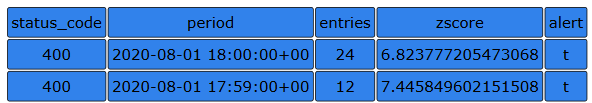

The first alert happened at `17:59`, and a minute later, the **z-score** was still high with a large number of entries, and so we classified the next rows at `18:00` as an anomaly as well.

If you think of an alerting system, we want to send an alert only when an anomaly first happens. We do not want to send an alert every minute until the **z-score** comes back below the threshold. In this case, we only want to send one alert at `17:59`. We do not want to send another alert a minute later at `18:00`.

Let’s remove alerts where the previous period was also classified as an alert:

```mysql
WITH calculations_over_window AS (
   SELECT
       status_code,
       period,
       entries,
       AVG(entries) OVER status_window as mean_entries,
       STDDEV(entries) OVER status_window as stddev_entries
   FROM
       server_log_summary
   WINDOW status_window AS (
       PARTITION BY status_code
       ORDER BY period
       ROWS BETWEEN 60 PRECEDING AND CURRENT ROW
   )
),

with_zscore AS (
   SELECT
       *,
       (entries - mean_entries) / NULLIF(stddev_entries::float, 0) as zscore
   FROM
       calculations_over_window
),

with_alert AS (

   SELECT
       *,
       entries > 10 AND zscore > 3 AS alert
   FROM
       with_zscore
),

with_previous_alert AS (
   SELECT
       *,
       LAG(alert) OVER (PARTITION BY status_code ORDER BY period) AS previous_alert
   FROM
       with_alert
)

SELECT
   status_code,
   period,
   entries,
   zscore,
   alert
FROM
   with_previous_alert
WHERE
   alert AND NOT previous_alert
ORDER BY
   period DESC;
```

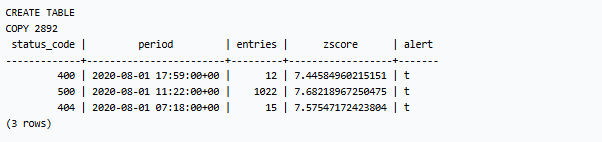

By eliminating alerts that were already triggered, we get a very small list of anomalies that may have happened during the day. Looking at the results, we can see what anomalies we would have discovered:

Anomaly in status code `400` at `17:59`. We also found that one earlier.

**400 status code entries**

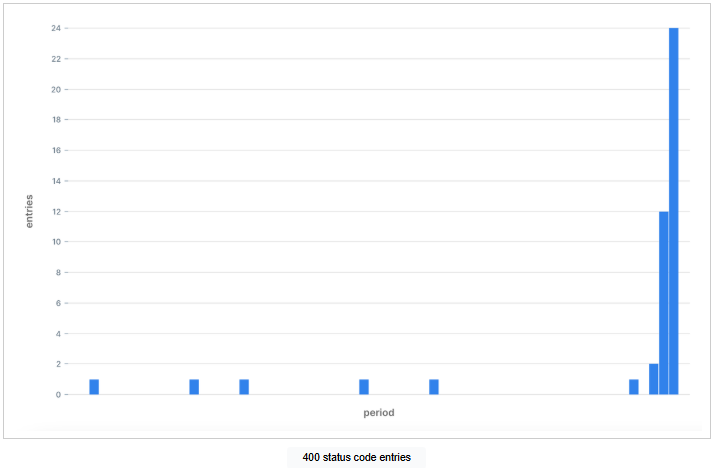

An anomaly in status code `500`. We spotted this one on the chart when we started.

**500 status code entries**

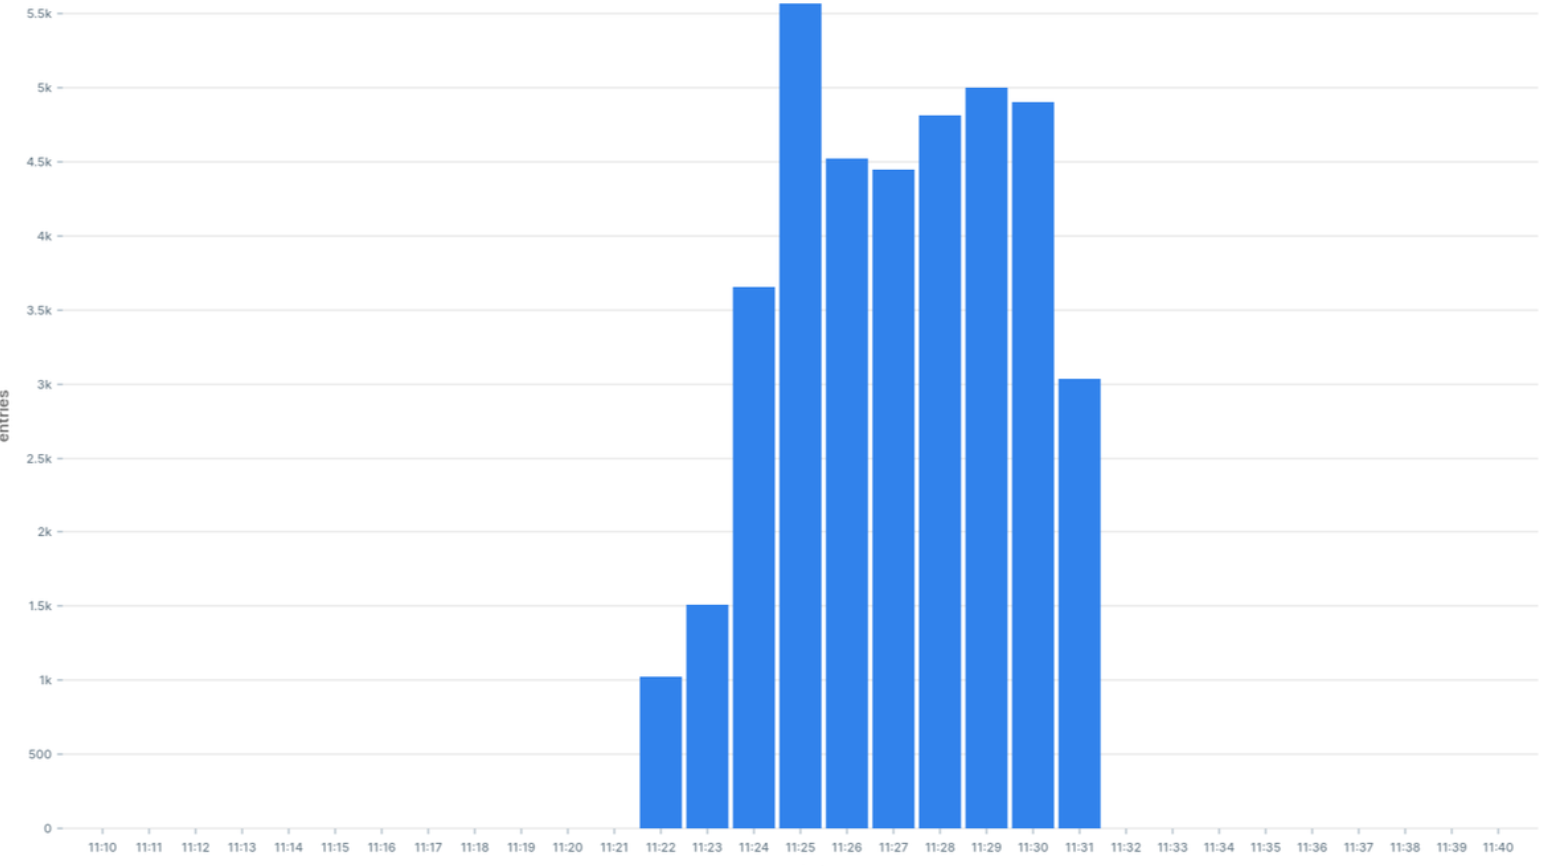

An anomaly in the status code `404`. This is a hidden anomaly that we did not know about until now.

**404 status code entries**

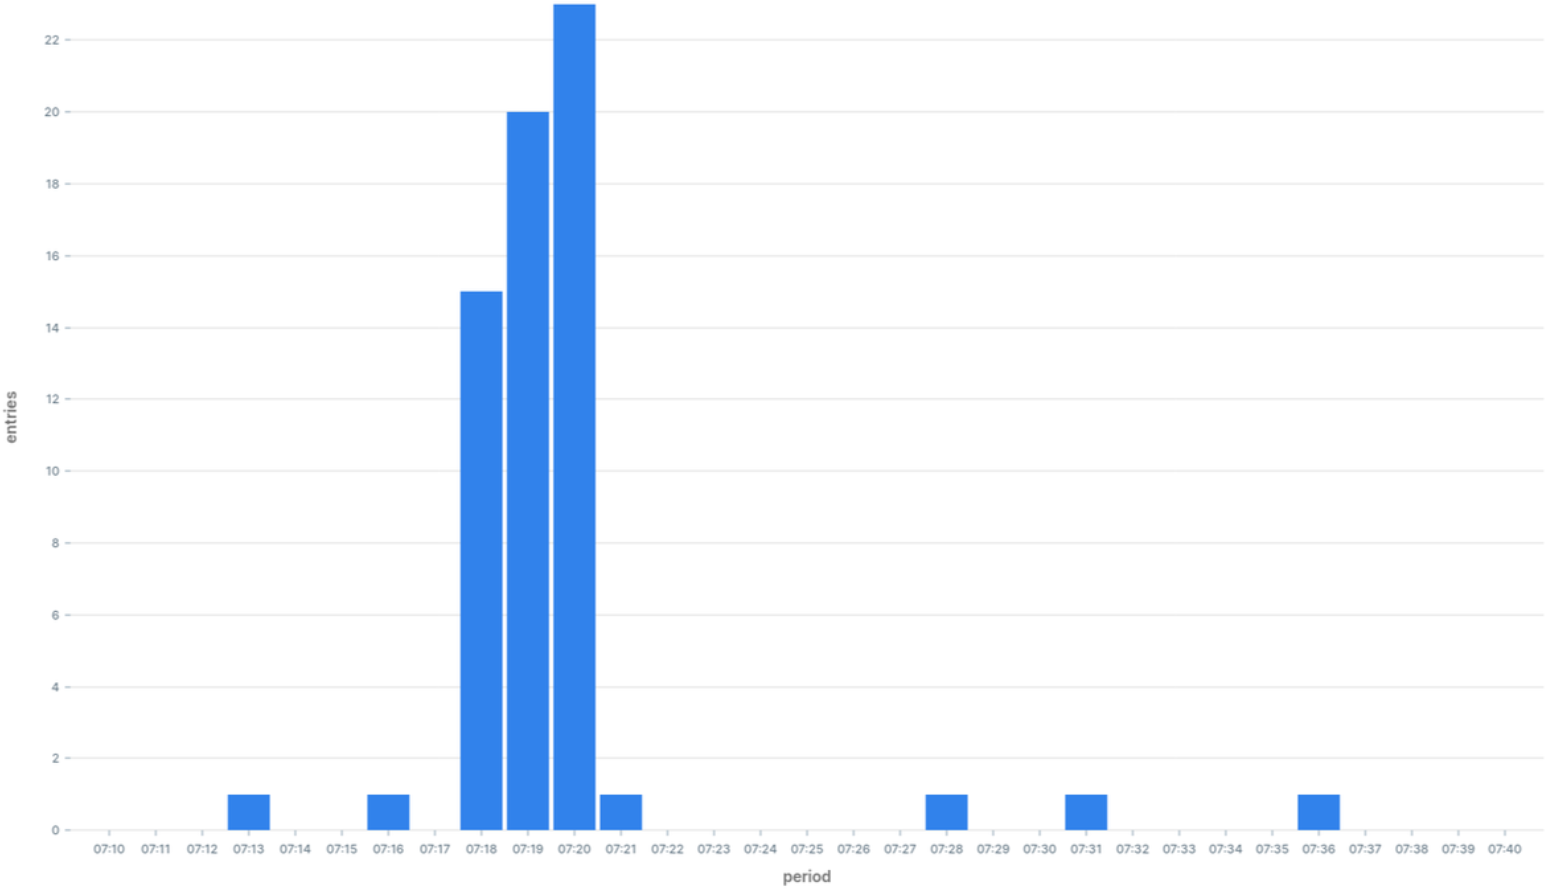

The query can now be used to fire alerts when it encounters an anomaly.


# Experiment with Different Values

In the process so far, we’ve used several constants in our calculations:
* **Lookback period**: How far back we calculate the mean and standard deviation for each status code. The value we used is `60` minutes.
* **Entries Threshold**: The least number of entries we want to get an alert for. The value we used is `10`.
* **Z-Score Threshold**: The z-score after which we classify the value as an anomaly. The value we used is `6`.

Now that we have a working query to backtest, we can experiment with different values.

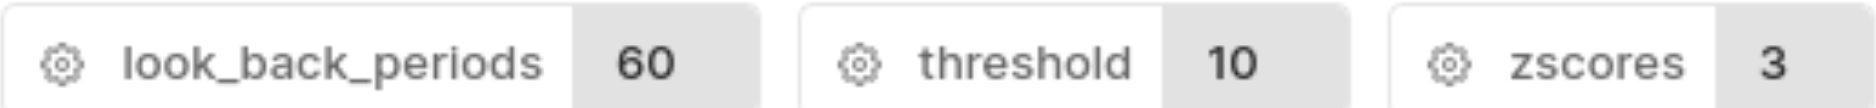

This is a chart showing the alerts our system identified in the past 12 hours:

**Alert chart**

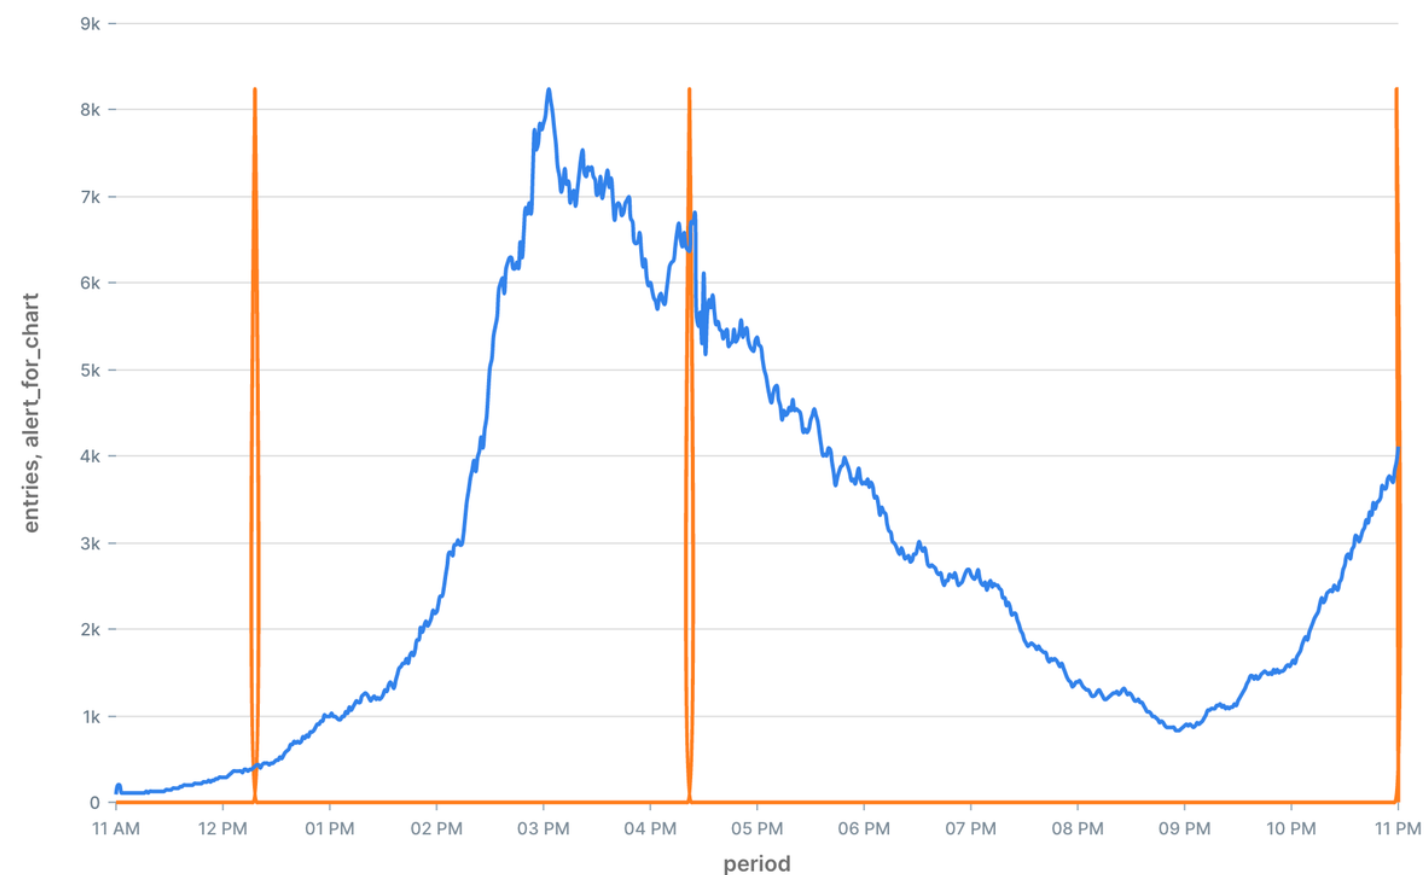

To get a sense of each parameter, let’s adjust the values and see how it affects the number and quality of alerts we get.

If we decrease the value of the z-score threshold from 3 to 1, we should get more alerts. 

With a lower threshold, more values are likely to be considered an anomaly:

**Alert chart**

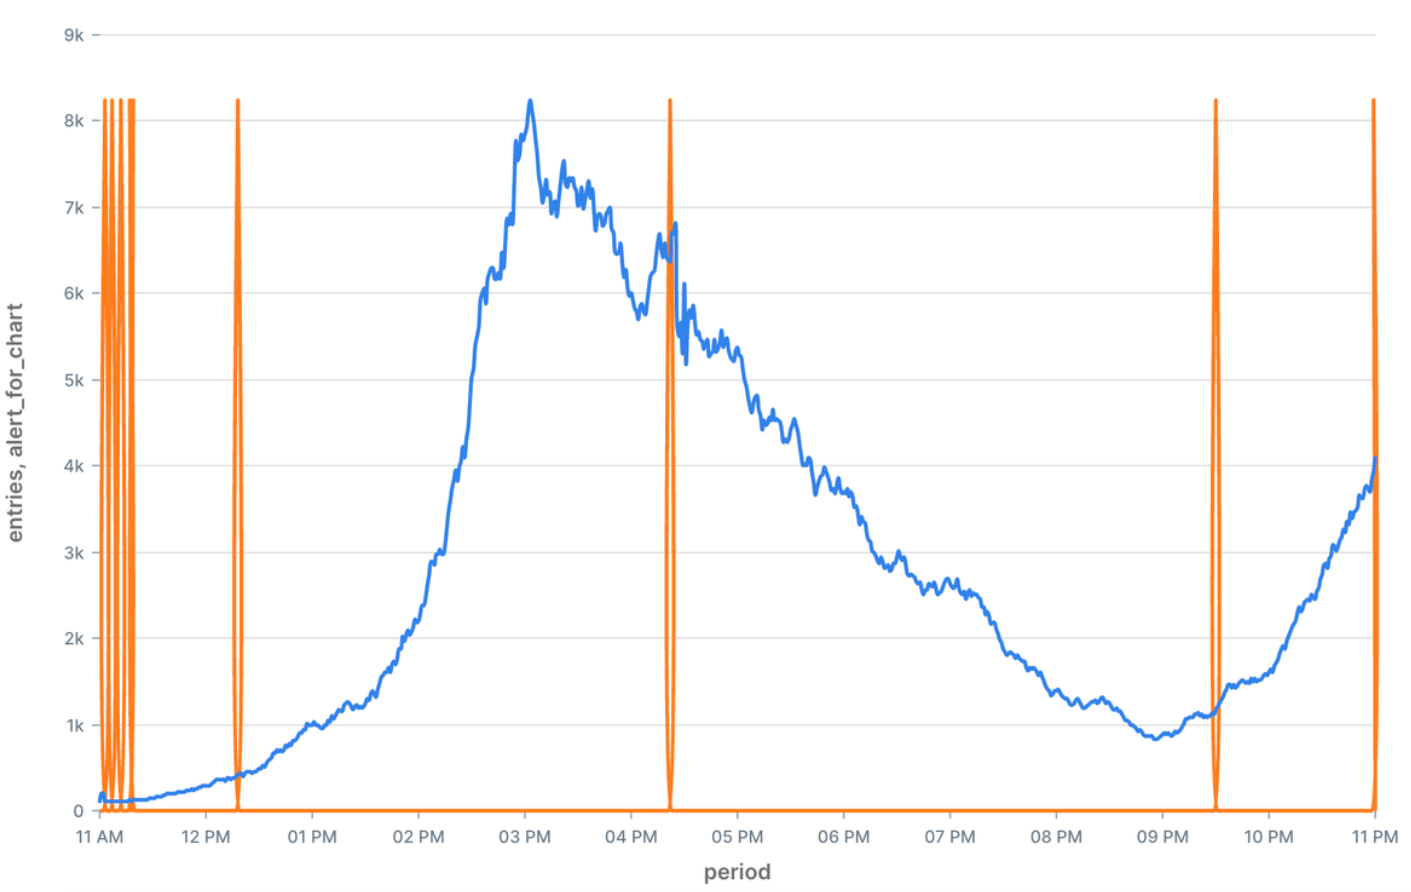

If we increase the entries threshold from 10 to 30, we should get fewer alerts:

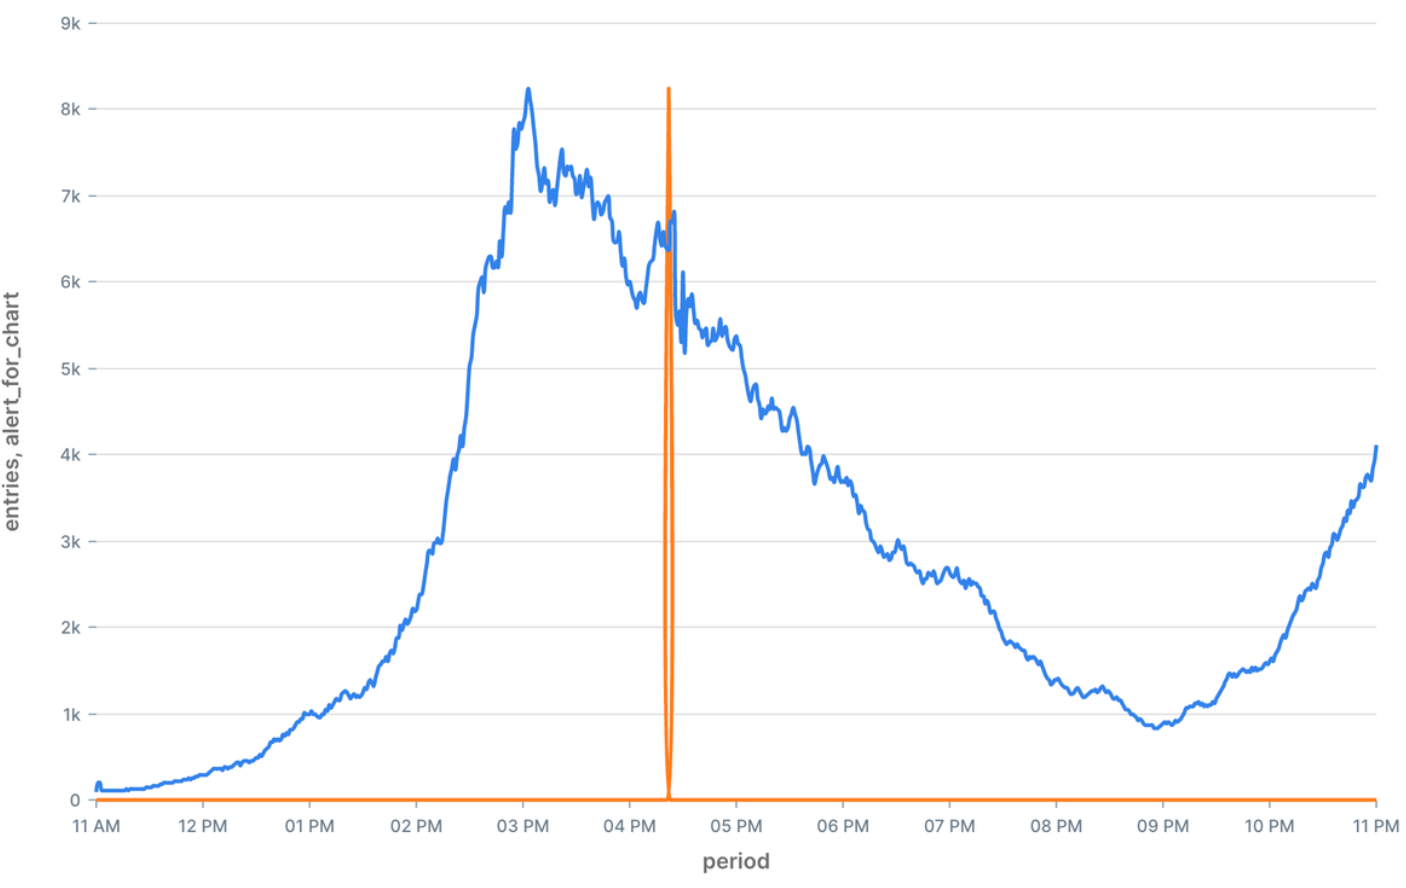

If we increase the backtest period from 60 minutes to 360 minutes, we get more alerts:

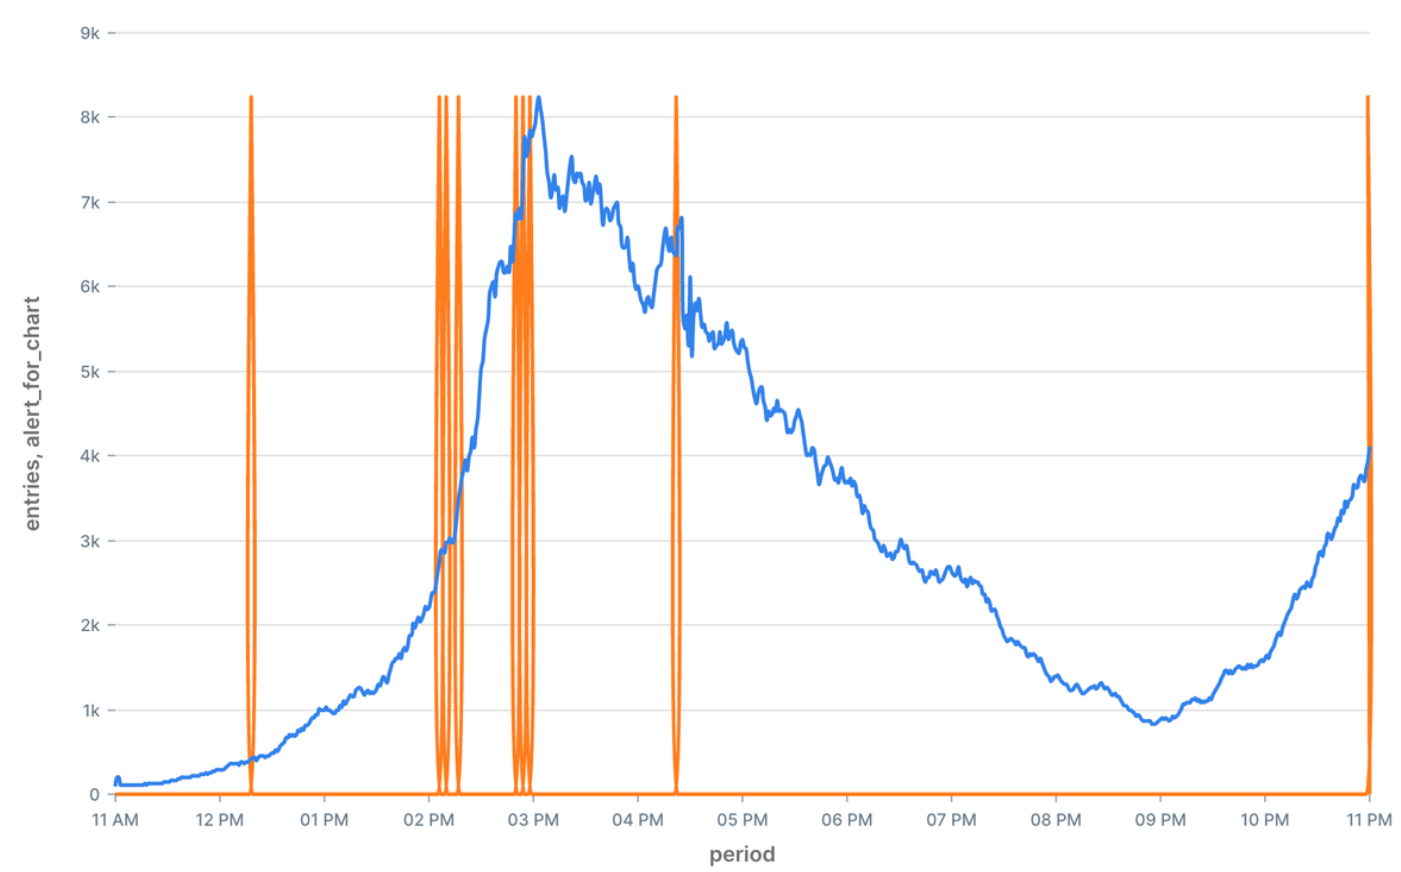

A good alerting system is a system that produces true alerts at a reasonable time. Using the backtesting query, you can experiment with different values that produce quality alerts you can act on.

# Weighted Mean

Using a z-score for detecting anomalies is an easy way to get started with anomaly detection and see results right away. But this method is not always the best choice, and if you do not get good alerts using this method, there are some improvements and other methods you can try using just SQL.

Our system uses a mean to determine a reasonable value and a lookback period to determine how far back to calculate the mean. In our case, we calculated the mean based on data from 1 hour ago.

Using this method of calculating mean gives the same weight to entries that happened 1 hour ago and to entries that just happened. Give more weight to recent entries at the expense of previous entries. The new weighted mean should become more sensitive to recent entries, and you may be able to identify anomalies quicker. To give more weight to recent entries, you can use a weighted average:

```mysql
SELECT
   status_code,
   avg(entries) as mean,
   sum(
      entries *
      (60 - extract('seconds' from '2020-08-01 17:00 UTC'::timestamptz - period))
   ) / (60 * 61 / 2) as weighted_mean
FROM
   server_log_summary
WHERE
   -- Last 60 periods
   period > '2020-08-01 17:00 UTC'::timestamptz
GROUP BY
   status_code;
```

```
 
CREATE TABLE
COPY 2892
 status_code |          mean          |   weighted_mean   
-------------+------------------------+-------------------
         500 | 0.15000000000000000000 | 0.295081967213115
         200 |  2779.1000000000000000 |  5467.08196721311
         404 | 0.13333333333333333333 | 0.262295081967213
         400 | 0.73333333333333333333 |  1.44262295081967
(4 rows)

```

You can see the difference between the mean and the weighted mean for each status code in the results.

A weighted average is a very common indicator used by stock traders. We used a linear weighted average, but there are also exponentially weighted averages and others you can try.

# Median

In statistics, a mean is not considered robust because extreme values influence it. Given our use case, the measure we use to identify extreme values is affected by those values we are trying to identify.

For example, at the beginning of the article, we used this series of values:

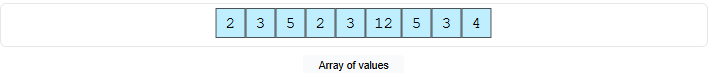

The mean of this series is `4.33`, and we detected `12` as an anomaly.

If the `12` were a `120`, the mean of the series would have been `16.33`. Hence, our **“reasonable”** value is heavily affected by the values it is supposed to identify.

The median is considered a more robust measure. The median of a series is the value that half the series is greater than, and half the series is less than:

```mysql
SELECT percentile_disc(0.5) within group(order by n)
FROM unnest(ARRAY[2, 3, 5, 2, 3, 120, 5, 3, 4]) as n;
```

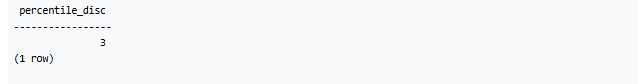

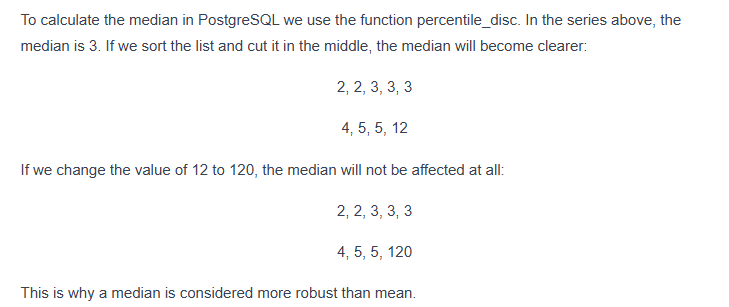

# Other Methods

**Mean absolute deviation**
* Median absolute deviation (MAD) is another way of finding anomalies in a series.
* MAD is considered better than the z-score for real-life data.
* MAD is calculated by finding the median of the deviations from the series median.
* Just for comparison, the standard deviation is the root square of the average square distance from the mean.

**Different measures**

We used the number of entries per minute as an indicator. However, depending on the use case, there might be other things you can measure that can yield better results. For example:
* To identify DOS (Denial-of-Service) attacks, you can monitor the ratio between unique IP addresses to HTTP requests.
* To reduce the number of false positives, you can normalize the responses to the proportion of the total responses. This way, for example, if you are using a flaky remote service that fails once after every certain amount of requests, using the proportion may not trigger an alert when the increase in errors correlates with an increase in overall traffic.

# Summary

In this module, we explored methods to detect anomalies and produce actionable alerts that can save us time and energy. 

We also learned to improve the efficiency of anomaly detection and our database model.

**Key takeaways**
* We gained a solid understanding of intermediate SQL concepts, including essential queries, filtering, grouping, sorting, and aggregate functions.
* We learned relational database modeling principles, such as entity-relationship modeling and normalization, to structure data effectively.
* We built foundational database knowledge covering schemas, keys, integrity constraints, and functional dependencies to maintain reliable data.
* We advance our SQL abilities with views, stored procedures, and triggers, enabling more efficient data operations and improved database performance.
* We developed query skills to handle complex data requirements using joins, nested queries, multi-table operations, and transactions for data consistency.
* We acquired techniques for detecting data anomalies, analyzing server logs, and backtesting irregularities to ensure database accuracy and operational efficiency.